## **Optimizing a Luxury Clothing Brand's Marketing Campaign Using Clustering**

The sales team at a luxury clothing store has collected data on customer age, income, their annual spend at the business, and the number of days since their last purchase. The company wants to start targeted marketing campaigns but doesn't know how many different types of customers they have. If they understood the number of different segments, it would help design the campaign better by helping define the channels to use, the messaging to employ, and more.

This project performs customer segmentation for the company which will help optimize the campaigns.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

data0 = pd.read_csv('/content/drive/MyDrive/Marketing-Analytics/Data/Clothing_Customers.csv')
data0.head()

,income,age,days_since_purchase,annual_spend
0,37453,48,504,4441
1,50775,50,566,4239
2,71047,41,326,5834
3,52239,52,259,5456
4,112343,27,279,1749


In [5]:
cluster_cols = data0.columns
data_scaled = data0.copy()

Standardizing Customer Data

Standardizing is done with the following steps:
 1. First, subtract the mean of the data from each data point. This centers the data around 0, to make the data easier to look at and interpret. 
 2. The second step is to divide the parameters by their standard deviation.

$ Z_i = \frac{x_i - mean(x)}{std(x)} $

By dividing all the values of Age by the standard deviation of the ages, we transform the data such that the standard deviation is equal to 1. When we do the same thing with the income, the standard deviation of the income will also be equal to 1. Therefore, a difference of 1 between two customers on either of these measures would indicate a similar level of difference between them. This ensures that all features have a similar influence on the formation of the clusters.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled[cluster_cols] = scaler.fit_transform(data0[cluster_cols])

Principle component analysis (PCA) is a dimensionality reduction technique in which components are calculated in place of original values; PCA summarizes or combines correlated features together to decrease the overall number of features.

 * principal component equation: $ \text{maximize } \frac{1}{n} \sum^n_{i=1} (\sum^p_{j=1} \phi_jx_{ij})^2 $ 

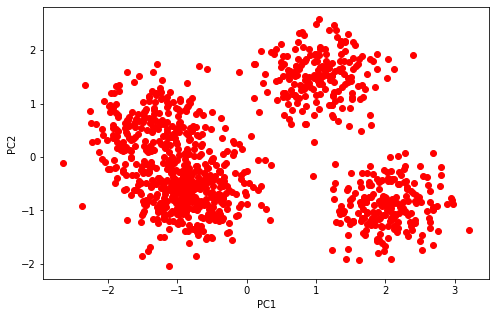

In [7]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca_res = pca.fit_transform(data_scaled[cluster_cols])

data_scaled['pc1'] = pca_res[:,0]
data_scaled['pc2'] = pca_res[:,1]

plt.figure(figsize=[8,5])
plt.scatter(data_scaled.pc1, data_scaled.pc2, color='red')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

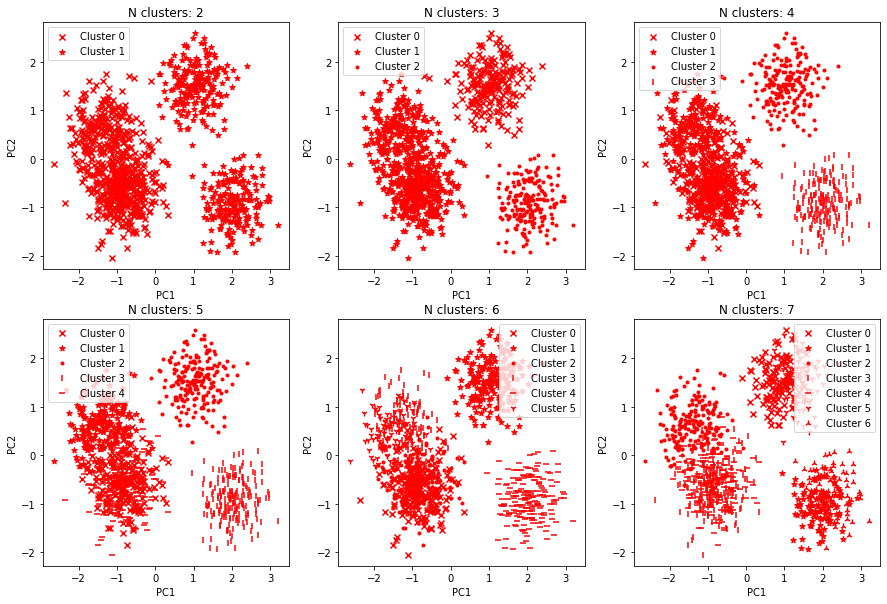

In [8]:
from sklearn.cluster import KMeans

markers = ['x', '*', '.', '|', '_', '1', '2']

plt.figure(figsize=[15,10])
for n in range(2,8):
    model = KMeans(n_clusters=n, random_state=42)
    data_scaled['Cluster']= model.fit_predict\
                            (data_scaled[cluster_cols])

    plt.subplot(2,3, n-1)
    for clust in range(n):
        temp = data_scaled[data_scaled.Cluster == clust]
        plt.scatter(temp.pc1, temp.pc2, \
                    marker=markers[clust], \
                    label="Cluster "+str(clust), \
                    color='red')
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.title("N clusters: "+str(n))

plt.show()

In [9]:
inertia_scores = []

for K in range(2,11):
    inertia = KMeans(n_clusters=K, random_state=42)\
              .fit(data_scaled).inertia_
    inertia_scores.append(inertia)

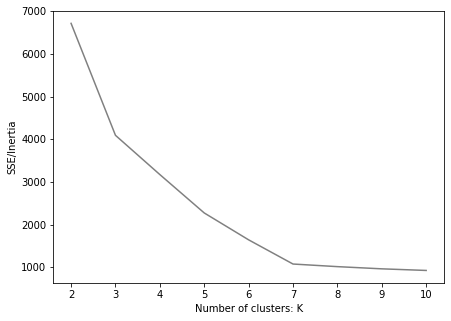

In [10]:
plt.figure(figsize=[7,5])
plt.plot(range(2,11), inertia_scores, color='gray')
plt.xlabel("Number of clusters: K")
plt.ylabel('SSE/Inertia')
plt.show()

There is an elbow in the plot at K=7, therefore, take 7 as the optimal number of clusters, the best value of K for the KMeans algorithm.

## **Evaluating Clustering on Customer Data**

Over the past year, the marketing team launched 32 initiatives to increase its sales. Your team has acquired data that tells you which customers have responded to which of the 32 marketing initiatives recently (this data is present within the customer_offers.csv file). The business goal is to improve future marketing campaigns by targeting them precisely, so they can provide offers customized to groups that tend to respond to similar offers. The solution is to build customer segments based on the responses of the customers to past initiatives.

In [11]:
import pandas as pd
from sklearn import cluster
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Marketing-Analytics/Data/customer_offers.csv')

In [13]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [14]:
from sklearn import model_selection

X_train, X_test = model_selection.train_test_split(df, random_state = 100)

Silhouette score - The silhouette score is a formal measure of how well a clustering fits the data. The higher the score, the better the clusters are. The score is calculated for each data point separately, and the average is taken as a measure of how well the model fits the whole dataset altogether.

There are two main components to the score. The first component measures how well the data point fits into the cluster that it is assigned to. This is defined as the average distance between it and all other members of that same cluster. The second component measures how well the data point fits into the next nearest cluster. It is calculated in the same way by measuring the average distance between the data point and all the data points assigned to the next nearest cluster. The difference between these two numbers can be taken as a measure of how well the data point fits into the cluster it is assigned to as opposed to a different cluster.

Silhouette score is between −1 and 1: $ s(x_i) = \frac{b_{x_i} - a_{x_i}}{\text{max}(a_{x_i}, b_{x_i})} $
 * $x_i$ - data point
 * $a_{x_i}$ - the average distance between that data point and all other data points in the same cluster 
 * $b_{x_i} $ - the average distance between data point $x_i$ and the data points in the next nearest cluster

A negative score means that this data point is actually on average closer to the other cluster, whereas a high positive score means it's a much better fit to the cluster it is assigned to. A value close to 0 would mean that the sample is close to both clusters.

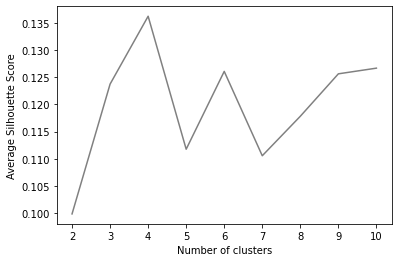

In [16]:
krange = list(range(2,11))
avg_silhouettes = []

for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=100)
    model.fit(X_train)
    cluster_assignments = model.predict(X_train)

    silhouette_avg = metrics.silhouette_score(X_train, cluster_assignments)
    avg_silhouettes.append(silhouette_avg)

plt.plot(krange, avg_silhouettes, color='gray')
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

The highest Silhouette score is at 4 clusters. 

In [17]:
model = cluster.KMeans(n_clusters=4, random_state=100)
model.fit(X_train)

km_labels = model.predict(X_test)
km_silhouette = metrics.silhouette_score(X_test, km_labels)

print('k-means silhouette score: ' + str(km_silhouette))

k-means silhouette score: 0.10342688033212433


Mean-shift clustering works by starting at each data point and shifting the data points (assigning them to clusters) toward the area of greatest density – that is, towards a natural cluster centroid. When all the data points have found their local density peak, the algorithm is complete.Bandwidth defines how far each data point will look when searching for a higher density area.

In [18]:
bandwidth = cluster.estimate_bandwidth(X_train, quantile=0.1)

ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

ms_labels = ms.predict(X_test)

ms_silhouette = metrics.silhouette_score(X_test, ms_labels)
print('mean-shift silhouette score: ' + str(ms_silhouette))

mean-shift silhouette score: 0.07308587709358311


In [20]:
!pip install kmodes

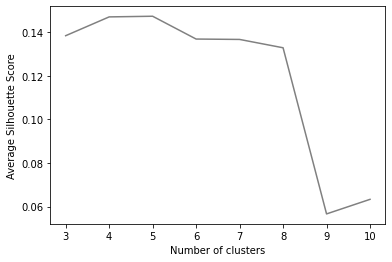

In [21]:
from kmodes.kmodes import KModes

krange = list(range(3,11))
avg_silhouettes = []

for n in krange:
    
    km = KModes(n_clusters=n, random_state=100)
    km.fit(X_train)

    kmode_labels = km.predict(X_train)
    kmode_silhouette = metrics.silhouette_score\
                       (X_train, kmode_labels)
    avg_silhouettes.append(kmode_silhouette)

plt.plot(krange, avg_silhouettes, color='gray')
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

In [22]:
km = KModes(n_clusters=4, random_state=100)
km.fit(X_train)

kmode_labels = km.predict(X_test)
kmode_silhouette = metrics.silhouette_score\
                   (X_test, kmode_labels)

print('k-mode silhouette score: ' + str(kmode_silhouette))

k-mode silhouette score: 0.11750917239635501
